In [1]:
import os 
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread,imsave
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input,InputLayer, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from sklearn.metrics import classification_report

In [2]:
def efficientnet_row(optimizer, loss, metrics, shape):
    image_input = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=shape)  # Change model to EfficientNet

    for layer in image_input.layers:
        layer.trainable = False
        layer._name = layer._name + str('_img')

    y = Flatten()(image_input.output)
    c = Dropout(0.4)(y)
    c = Dense(512)(c)
    c = Dense(256)(c)
    c = Dense(128)(c)
    output_layer = Dense(3, activation='softmax')(c)

    model = Model(inputs=image_input.input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [3]:
root='/blue/oguzhan/swetha.lenkala/AFFINE_REG_SKS_MASK_2D_IMAGES_DIR'

In [4]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')
     

In [5]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [6]:
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 1901 images belonging to 3 classes.
Found 478 images belonging to 3 classes.


In [7]:
EPOCH = 100
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

2024-04-14 19:32:33.198195: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 19:32:34.045277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [14]:
savepath = 'models'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'efficientnet_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}efficientnet_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/efficientnet_50_0.0001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("efficientnet_50_0.0001.npy",p2 )   

Epoch 1/50


2024-03-19 19:30:05.772348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 49s 89ms/step - loss: 7.0454 - Accuracy: 0.4766 - AD_Precision: 0.2148 - CN_Precision: 0.3656 - MCI_Precision: 0.5954 - AD_Recall: 0.1747 - CN_Recall: 0.3223 - MCI_Recall: 0.5949 - val_loss: 1.2436 - val_Accuracy: 0.5335 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.5833 - val_MCI_Precision: 0.5300 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.1892 - val_MCI_Recall: 0.9247
Epoch 2/50
476/476 [==============================] - 28s 59ms/step - loss: 1.3585 - Accuracy: 0.5076 - AD_Precision: 0.2780 - CN_Precision: 0.4111 - MCI_Precision: 0.6055 - AD_Recall: 0.2018 - CN_Recall: 0.3320 - MCI_Recall: 0.6319 - val_loss: 1.3921 - val_Accuracy: 0.5272 - val_AD_Precision: 0.4545 - val_CN_Precision: 0.8000 - val_MCI_Precision: 0.5394 - val_AD_Recall: 0.1648 - val_CN_Recall: 0.0811 - val_MCI_Recall: 0.9163
Epoch 3/50
476/476 [==============================] - 29s 62ms/step - loss: 1.5293 - Accuracy: 0.5018 - AD_Precision: 0.3015 - CN_Precision: 0.

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


NameError: name 'model05' is not defined

              precision    recall  f1-score   support

          AD       0.64      0.82      0.72        91
          CN       0.82      0.87      0.84       148
         MCI       0.89      0.75      0.81       239

    accuracy                           0.80       478
   macro avg       0.78      0.82      0.79       478
weighted avg       0.82      0.80      0.81       478



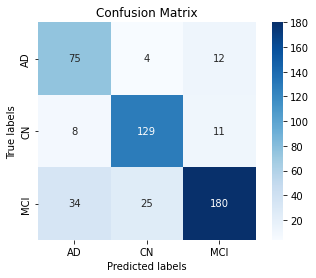

In [15]:
p2 = model04.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("efficientnet_50_0.0001.npy",p2 )   

In [16]:
model04.save(f"{savepath}/efficientnet_50_0.0001.h5")

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
476/476 [==============================] - 32s 58ms/step - loss: 1.8129 - Accuracy: 0.4513 - AD_Precision: 0.2109 - CN_Precision: 0.3193 - MCI_Precision: 0.5746 - AD_Recall: 0.1747 - CN_Recall: 0.2796 - MCI_Recall: 0.5920 - val_loss: 1.1389 - val_Accuracy: 0.4895 - val_AD_Precision: 0.5455 - val_CN_Precision: 0.4217 - val_MCI_Precision: 0.5979 - val_AD_Recall: 0.0659 - val_CN_Recall: 0.6554 - val_MCI_Recall: 0.4728
Epoch 2/50
476/476 [==============================] - 25s 52ms/step - loss: 1.6071 - Accuracy: 0.4918 - AD_Precision: 0.2575 - CN_Precision: 0.3904 - MCI_Precision: 0.6037 - AD_Recall: 0.2078 - CN_Recall: 0.3456 - MCI_Recall: 0.6129 - val_loss: 1.7513 - val_Accuracy: 0.5188 - val_AD_Precision: 0.7500 - val_CN_Precision: 0.8333 - val_MCI_Precision: 0.5130 - val_AD_Recall: 0.0659 - val_CN_Recall: 0.0338 - val_MCI_Recall: 0.9916
Epoch 3/50
476/476 [==============================] - 28s 58ms/step - loss: 1.4468 - Accuracy: 0.5218 - AD_Precision: 0.2930 - CN_Precision:

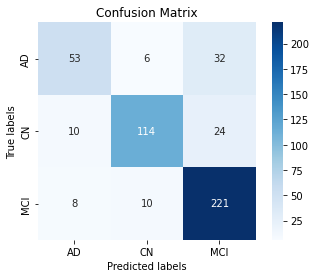

In [24]:
savepath = 'models'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'efficientnet_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}efficientnet_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/efficientnet_50_0.000001.h5")
p2 = model04.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("efficientnet_50_0.000001.npy",p2 )   

Epoch 1/50


2024-03-20 11:00:15.260116: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 40s 61ms/step - loss: 13.7586 - Accuracy: 0.4129 - AD_Precision: 0.1843 - CN_Precision: 0.2837 - MCI_Precision: 0.5491 - AD_Recall: 0.1837 - CN_Recall: 0.2699 - MCI_Recall: 0.5408 - val_loss: 1.6368 - val_Accuracy: 0.4540 - val_AD_Precision: 0.1860 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.5184 - val_AD_Recall: 0.1758 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 0.8243
Epoch 2/50
476/476 [==============================] - 25s 52ms/step - loss: 3.0362 - Accuracy: 0.4308 - AD_Precision: 0.2054 - CN_Precision: 0.3111 - MCI_Precision: 0.5646 - AD_Recall: 0.2078 - CN_Recall: 0.2893 - MCI_Recall: 0.5474 - val_loss: 3.9092 - val_Accuracy: 0.3096 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.3082 - val_MCI_Precision: 0.0000e+00 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.9932 - val_MCI_Recall: 0.0000e+00
Epoch 3/50
476/476 [==============================] - 25s 52ms/step - loss: 2.8283 - Accuracy: 0.4482 - AD_Precision: 0.2143 -

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.79      0.42      0.55        91
          CN       0.86      0.70      0.77       148
         MCI       0.73      0.94      0.82       239

    accuracy                           0.77       478
   macro avg       0.79      0.68      0.71       478
weighted avg       0.78      0.77      0.75       478



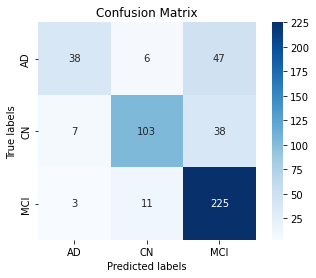

In [9]:
savepath = 'models'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'efficientnet_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}efficientnet_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/efficientnet_50_0.0001.h5")
p2 = model04.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("efficientnet_50_0.0001.npy",p2 )   

Epoch 1/50
476/476 [==============================] - 55s 106ms/step - loss: 6.4294 - Accuracy: 0.4472 - AD_Precision: 0.3095 - CN_Precision: 0.3569 - MCI_Precision: 0.5787 - AD_Recall: 0.3168 - CN_Recall: 0.4570 - MCI_Recall: 0.4834 - val_loss: 2.3632 - val_Accuracy: 0.5586 - val_AD_Precision: 0.2778 - val_CN_Precision: 0.5270 - val_MCI_Precision: 0.5935 - val_AD_Recall: 0.0549 - val_CN_Recall: 0.5270 - val_MCI_Recall: 0.7699
Epoch 2/50
476/476 [==============================] - 32s 66ms/step - loss: 4.0351 - Accuracy: 0.5008 - AD_Precision: 0.2888 - CN_Precision: 0.4039 - MCI_Precision: 0.6163 - AD_Recall: 0.2861 - CN_Recall: 0.4000 - MCI_Recall: 0.6110 - val_loss: 4.2188 - val_Accuracy: 0.3096 - val_AD_Precision: 0.2193 - val_CN_Precision: 0.5229 - val_MCI_Precision: 0.6364 - val_AD_Recall: 0.8242 - val_CN_Recall: 0.3851 - val_MCI_Recall: 0.0586
Epoch 3/50
476/476 [==============================] - 31s 65ms/step - loss: 2.9299 - Accuracy: 0.5423 - AD_Precision: 0.3486 - CN_Precision

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.89      0.53      0.66        91
          CN       0.79      0.91      0.84       148
         MCI       0.82      0.87      0.85       239

    accuracy                           0.82       478
   macro avg       0.83      0.77      0.78       478
weighted avg       0.82      0.82      0.81       478



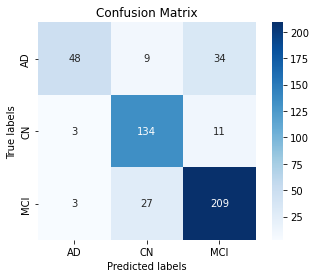

In [10]:
savepath = 'Finetuning/Efficientnet/RMSprop/Efficientnet_50_0.00001'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'efficientnet_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}efficientnet_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/efficientnet_50_0.00001.h5")
p2 = model04.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("efficientnet_50_0.00001.npy",p2 )   

Epoch 1/50
476/476 [==============================] - 43s 81ms/step - loss: 1.9167 - Accuracy: 0.5183 - AD_Precision: 0.3272 - CN_Precision: 0.4281 - MCI_Precision: 0.6156 - AD_Recall: 0.2506 - CN_Recall: 0.3725 - MCI_Recall: 0.6404 - val_loss: 1.6397 - val_Accuracy: 0.5021 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.5000 - val_MCI_Precision: 0.5101 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.0541 - val_MCI_Recall: 0.9498
Epoch 2/50
476/476 [==============================] - 31s 65ms/step - loss: 1.8270 - Accuracy: 0.4640 - AD_Precision: 0.2399 - CN_Precision: 0.3232 - MCI_Precision: 0.5943 - AD_Recall: 0.1958 - CN_Recall: 0.2893 - MCI_Recall: 0.5977 - val_loss: 2.7004 - val_Accuracy: 0.5000 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.5000 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 1.0000
Epoch 3/50
476/476 [==============================] - 31s 66ms/step - loss: 1.6372 - Accuracy: 0.5118 - AD_Precision

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.80      0.44      0.57        91
          CN       0.76      0.90      0.82       148
         MCI       0.79      0.84      0.81       239

    accuracy                           0.78       478
   macro avg       0.78      0.73      0.73       478
weighted avg       0.78      0.78      0.77       478



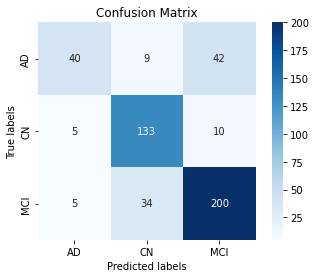

In [11]:
savepath = 'Finetuning/Efficientnet/RMSprop/Efficientnet_50_0.00001/'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'efficientnet_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}efficientnet_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/efficientnet_50_0.000001.h5")
p2 = model04.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("efficientnet_50_0.000001.npy",p2 )  

In [9]:
savepath = 'Finetuning/efficientnet/efficientnet_70_0.00001'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'efficientnet_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}efficientnet_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/efficientnet_70_0.00001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("efficientnet_70_0.00001.npy",p2 )   

Epoch 1/70


2024-04-14 17:46:38.353722: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 45s 79ms/step - loss: 4.2733 - Accuracy: 0.4671 - AD_Precision: 0.2484 - CN_Precision: 0.3458 - MCI_Precision: 0.5912 - AD_Recall: 0.2380 - CN_Recall: 0.3398 - MCI_Recall: 0.5968 - val_loss: 3.2821 - val_Accuracy: 0.3724 - val_AD_Precision: 0.4324 - val_CN_Precision: 0.3487 - val_MCI_Precision: 0.7273 - val_AD_Recall: 0.1758 - val_CN_Recall: 0.9730 - val_MCI_Recall: 0.0669
Epoch 2/70
476/476 [==============================] - 32s 67ms/step - loss: 3.0595 - Accuracy: 0.5339 - AD_Precision: 0.3222 - CN_Precision: 0.4370 - MCI_Precision: 0.6504 - AD_Recall: 0.3193 - CN_Recall: 0.4311 - MCI_Recall: 0.6442 - val_loss: 3.0318 - val_Accuracy: 0.5523 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.7308 - val_MCI_Precision: 0.5305 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.2568 - val_MCI_Recall: 0.9456
Epoch 3/70
476/476 [==============================] - 32s 66ms/step - loss: 1.8329 - Accuracy: 0.5718 - AD_Precision: 0.3933 - CN_Precision: 0.

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


NameError: name 'model05' is not defined

              precision    recall  f1-score   support

          AD       0.81      0.63      0.71        91
          CN       0.89      0.84      0.86       148
         MCI       0.82      0.92      0.87       239

    accuracy                           0.84       478
   macro avg       0.84      0.79      0.81       478
weighted avg       0.84      0.84      0.84       478



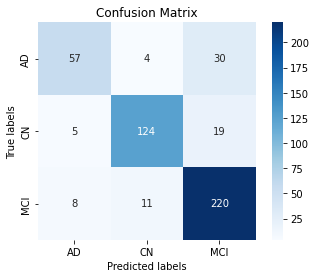

In [10]:
p2 = model04.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("efficientnet_70_0.00001.npy",p2 )   

Epoch 1/100


2024-04-14 19:32:48.750314: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 42s 71ms/step - loss: 4.0244 - Accuracy: 0.4645 - AD_Precision: 0.2323 - CN_Precision: 0.3710 - MCI_Precision: 0.5834 - AD_Recall: 0.2169 - CN_Recall: 0.3631 - MCI_Recall: 0.5873 - val_loss: 6.5886 - val_Accuracy: 0.5084 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.5000 - val_MCI_Precision: 0.5085 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.0270 - val_MCI_Recall: 1.0000
Epoch 2/100
476/476 [==============================] - 32s 67ms/step - loss: 3.0701 - Accuracy: 0.5124 - AD_Precision: 0.3127 - CN_Precision: 0.4127 - MCI_Precision: 0.6276 - AD_Recall: 0.3042 - CN_Recall: 0.4039 - MCI_Recall: 0.6300 - val_loss: 2.0052 - val_Accuracy: 0.6067 - val_AD_Precision: 1.0000 - val_CN_Precision: 0.6606 - val_MCI_Precision: 0.5912 - val_AD_Recall: 0.0330 - val_CN_Recall: 0.4865 - val_MCI_Recall: 0.8954
Epoch 3/100
476/476 [==============================] - 30s 63ms/step - loss: 1.7895 - Accuracy: 0.5886 - AD_Precision: 0.4108 - CN_Precision: 

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.86      0.71      0.78        91
          CN       0.79      0.91      0.85       148
         MCI       0.88      0.85      0.86       239

    accuracy                           0.84       478
   macro avg       0.84      0.82      0.83       478
weighted avg       0.85      0.84      0.84       478



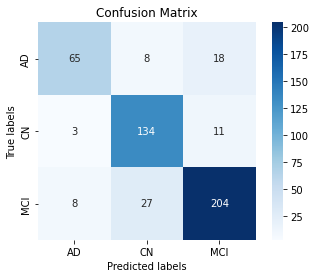

In [8]:
savepath = 'Finetuning/efficientnet/efficientnet_100_0.00001/'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'efficientnet_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}efficientnet_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/efficientnet_100_0.00001.h5")
p2 = model04.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("efficientnet_100_0.00001.npy",p2 )   